In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [2]:
!pip install Pillow

In [3]:
from torchvision.datasets import OxfordIIITPet
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((144,144)),
    transforms.ToTensor()
])

In [4]:
dataset = OxfordIIITPet(root=".", download=True, transform=transform)

100%|██████████| 791918971/791918971 [00:35<00:00, 22480208.49it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10616616.62it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [5]:
from PIL import Image
import os
dataset_dir = "./oxford-iiit-pet/"
image_dir = os.path.join(dataset_dir, "images")
#lay ten cua tat ca tep trong thu muc
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
images = []
for image_file in image_files:
  path = os.path.join(image_dir, image_file)
  image = Image.open(path)
  images.append(image)


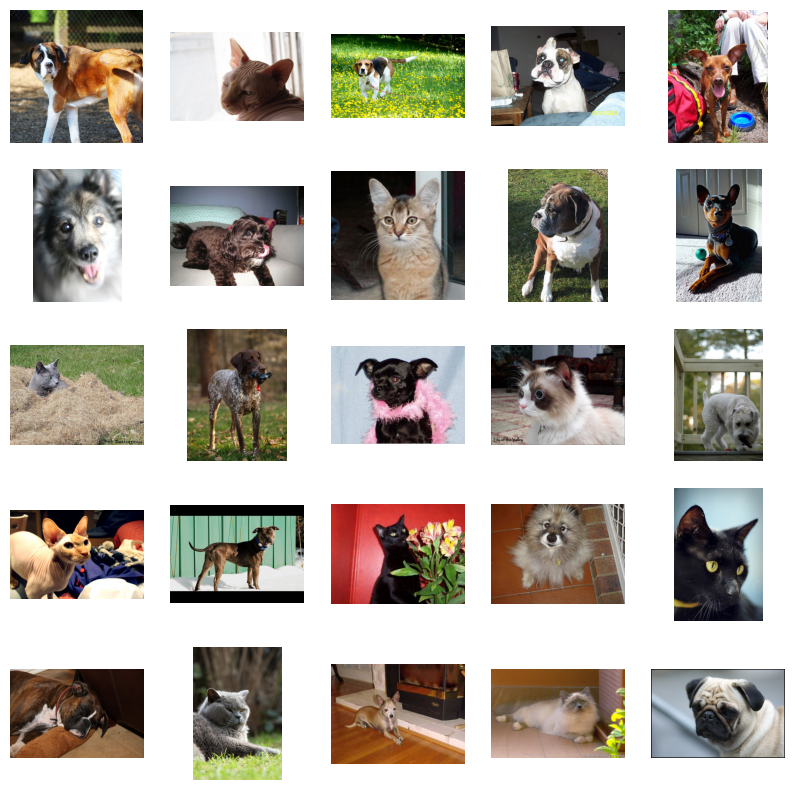

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i])
  plt.axis("off")
plt.show()

In [7]:
image, label = dataset[0]
image.shape, label, dataset.classes, len(dataset)

(torch.Size([3, 144, 144]),
 0,
 ['Abyssinian',
  'American Bulldog',
  'American Pit Bull Terrier',
  'Basset Hound',
  'Beagle',
  'Bengal',
  'Birman',
  'Bombay',
  'Boxer',
  'British Shorthair',
  'Chihuahua',
  'Egyptian Mau',
  'English Cocker Spaniel',
  'English Setter',
  'German Shorthaired',
  'Great Pyrenees',
  'Havanese',
  'Japanese Chin',
  'Keeshond',
  'Leonberger',
  'Maine Coon',
  'Miniature Pinscher',
  'Newfoundland',
  'Persian',
  'Pomeranian',
  'Pug',
  'Ragdoll',
  'Russian Blue',
  'Saint Bernard',
  'Samoyed',
  'Scottish Terrier',
  'Shiba Inu',
  'Siamese',
  'Sphynx',
  'Staffordshire Bull Terrier',
  'Wheaten Terrier',
  'Yorkshire Terrier'],
 3680)

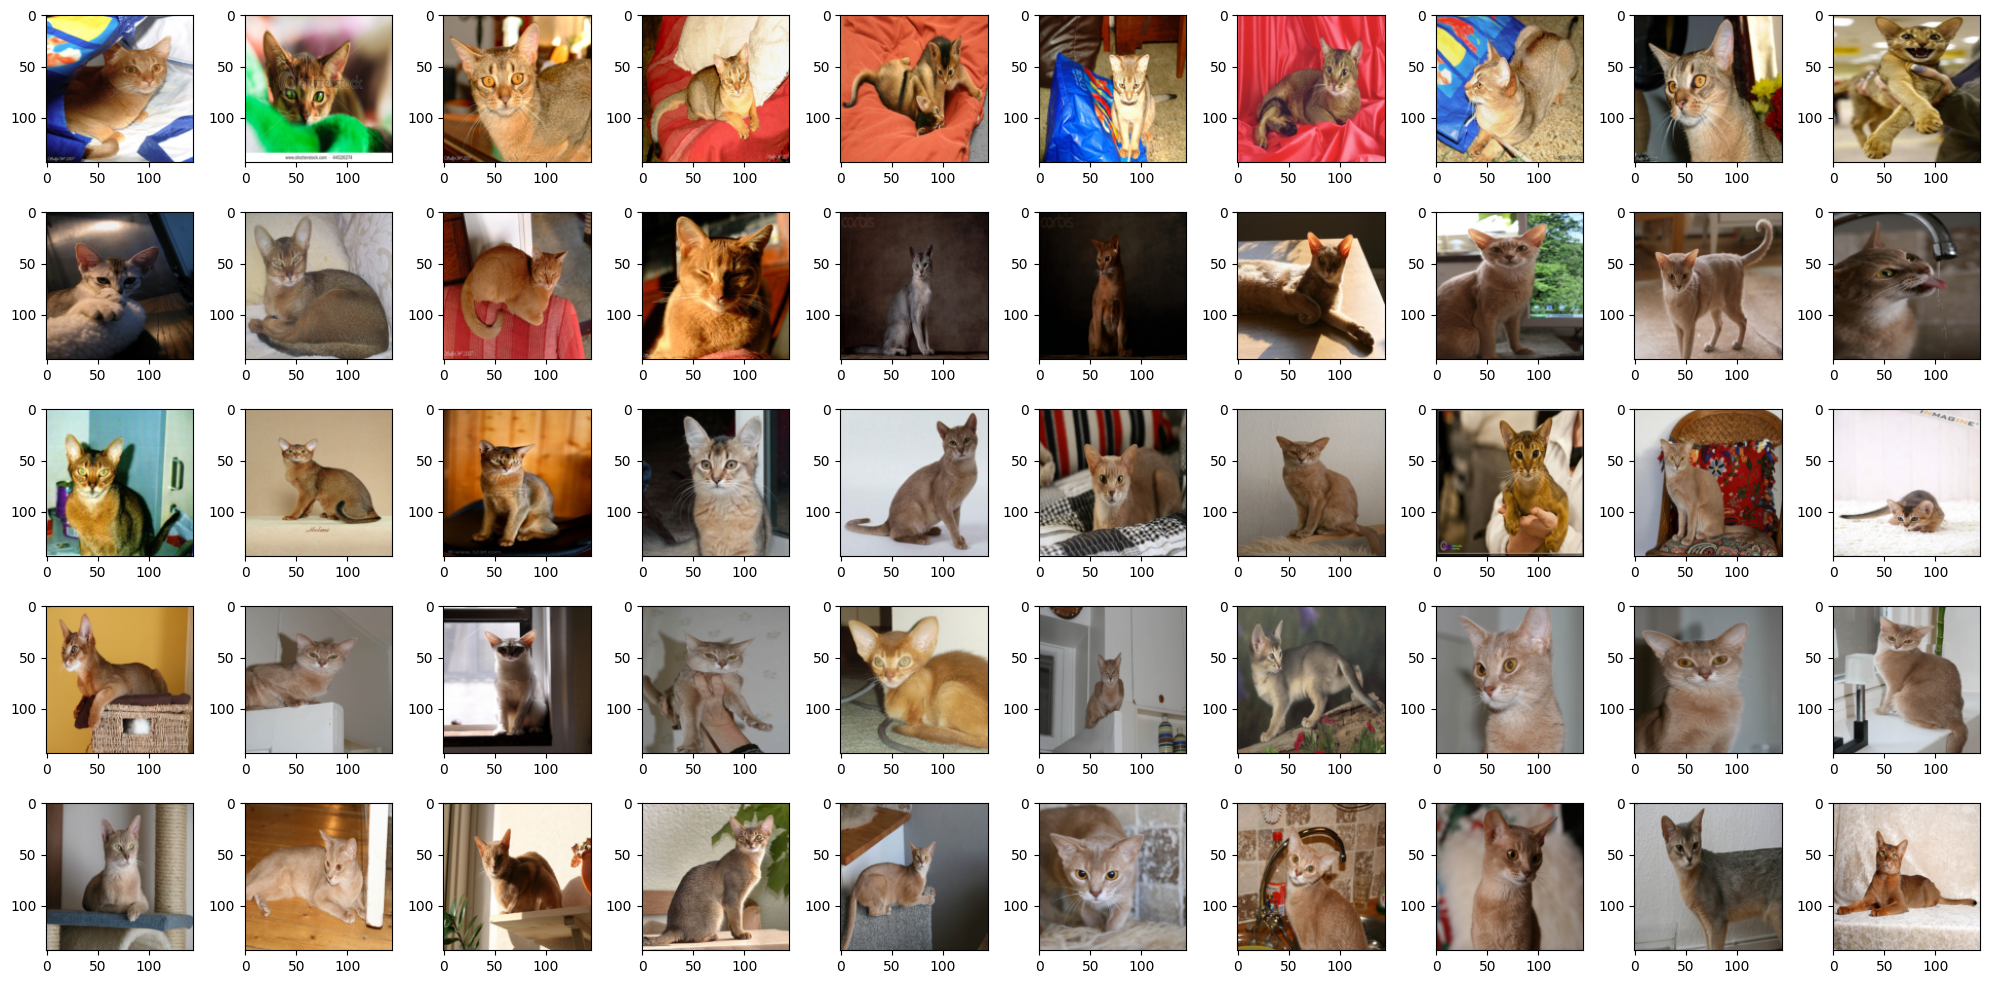

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 10, figsize=(20,10))
for i in range(50):
  image, label = dataset[i]
  ax = axes[i//10, i%10]
  ax.imshow(image.permute(1,2,0))
plt.tight_layout()
plt.show()

In [42]:
from torch import nn
from einops.layers.torch import Rearrange

class PatchEmbedding(nn.Module):
  def __init__(self, n_channel=3, patch_size=8, embed_dim=128):
    super().__init__()
    #B, H, W, C --> B, N, (p1*p2*C)   [N = (H*W)/(p1*p2)]
    #N duoc xem la chieu dai cua sequence (do dai cua cau)
    #(p1*p2*C) --> embed_dim
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
        nn.Linear(n_channel*patch_size*patch_size, embed_dim)
    )

  def forward(self, x):
    #x: B, W, H, C
    x = self.projection(x)
    return x

x = dataset[0][0].unsqueeze(0)
patch_model = PatchEmbedding()
res = patch_model(x)
print(x.shape, res.shape)

torch.Size([1, 3, 144, 144]) torch.Size([1, 324, 128])


In [10]:
class Attention(nn.Module):
  def __init__(self, dim, num_heads, dropout):
    super().__init__()
    self.num_heads = num_heads
    self.att = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
    self.k = nn.Linear(dim, dim)
    self.q = nn.Linear(dim, dim)
    self.v = nn.Linear(dim, dim)

  def forward(self, x):
    key = self.k(x)
    query = self.q(x)
    value = self.v(x)
    output, _ = self.att(query, key, value)
    return output


In [11]:
attn_model = Attention(dim=128, num_heads=4, dropout=0.0)
attn_model(res).shape

torch.Size([1, 324, 128])

In [12]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn
  def forward(self, x, **args):
    return self.fn(self.norm(x), **args)

In [13]:
norm_model = PreNorm(dim=128, fn=Attention(dim=128, num_heads=4, dropout=0.0))
norm_model(res).shape

torch.Size([1, 324, 128])

In [14]:
class FeedForward(nn.Module):
  def __init__(self, dim, hidden_dim, dropout=0.):
    super().__init__()
    self.ff = nn.Sequential(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
    )
  def forward(self, x):
    return self.ff(x)

In [15]:
ff = FeedForward(dim=128, hidden_dim=256)
ff(res).shape

torch.Size([1, 324, 128])

In [16]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn
  def forward(self, x, **args):
    res = x
    x = self.fn(x, **args)
    x += res
    return x

In [17]:
res_model = ResidualAdd(Attention(dim=128, num_heads=4, dropout=0.))
res_model(res).shape

torch.Size([1, 324, 128])

In [18]:
class Transformer(nn.Module):
  def __init__(self, dim, num_heads, dropout, n_layers):
    super().__init__()
    self.layers = nn.ModuleList([
        nn.ModuleList([
            PreNorm(dim=dim, fn=Attention(dim=dim, num_heads=num_heads,dropout=dropout)),
            PreNorm(dim=dim, fn=FeedForward(dim=dim, hidden_dim=dim, dropout=dropout))
        ])
        for _ in range(n_layers)
    ])
  def forward(self, x):
    for attn, ff in self.layers:
      x = attn(x) + x
      x = ff(x) + x
    return x



In [19]:
import torch
torch.randn(1,2,3)

tensor([[[-0.8312,  0.1482,  1.2671],
         [-1.2831, -0.2943, -1.0891]]])

In [20]:
len(dataset.classes)

37

In [43]:
from einops import repeat
class ViT(nn.Module):
  def __init__(self, n_channel=3, img_size=144, patch_size=4, embed_dim=32, num_heads=2, dropout=0.1, n_layers=6, out_dim=37):
    super().__init__()
    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.n_layers = n_layers
    self.num_patch = (img_size // patch_size)**2

    #patching
    self.patch_embedding = PatchEmbedding(n_channel=n_channel, patch_size=patch_size, embed_dim=embed_dim)
    #positional embedding
    self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patch + 1, embed_dim))
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    #transformer
    self.transformer = Transformer(dim=embed_dim,num_heads=num_heads,dropout=dropout,n_layers=n_layers)
    #classification layer
    self.head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, out_dim)
    )
  def forward(self, img):
    x = self.patch_embedding(img)
    b, n, _ = x.shape
    cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding[:, :(n+1)]
    x = self.transformer(x)
    return self.head(x[:, 0, :])





In [44]:
model = ViT()
print(model)
model(dataset[0][0].unsqueeze(0))

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (k): Linear(in_features=32, out_features=32, bias=True)
            (q): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (ff): Sequential(
              (0): Linear(in_features=32, o

tensor([[-0.3924,  0.5750, -0.4448,  0.8863, -0.7360,  0.5668,  0.4329, -0.0362,
         -0.0406, -0.1110,  0.4625,  0.4063,  0.4440,  0.1138, -0.2949,  1.2009,
         -0.4399, -0.4878, -0.6041, -0.6020, -0.0836, -0.1181, -0.0561,  0.1936,
         -0.4579,  0.4449, -0.2234,  0.0176,  0.1215,  0.9687, -0.4183, -0.4176,
         -1.0523,  1.6041, -0.3875, -0.8189,  0.5054]],
       grad_fn=<AddmmBackward0>)

In [23]:
from einops import repeat
temp = torch.randn(2,16,128)
cls = torch.randn(1, 1 , 128)
n = 16
tokens = repeat(cls, '() n d -> b n d', b = 2)
torch.cat((tokens, temp), dim=1).shape

temp = torch.randn(1,17,128)
temp[:,:(n+1), :].shape

torch.Size([1, 17, 128])

In [45]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)


In [25]:
for input, label in test_loader:
  print(input.shape, label.shape, len(test_loader.dataset))
  break

torch.Size([32, 3, 144, 144]) torch.Size([32]) 736


In [46]:
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)
num_epoch = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(num_epoch)):
  model.train()
  epoch_train_loss = 0.0
  for input, label in train_loader:
    input, label = input.to(device), label.to(device)
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    epoch_train_loss += loss.item()*input.size(0)

  if (epoch + 1) % 5 == 0:
    # model.eval()
    epoch_test_loss = 0.0

    for input, label in test_loader:
      input, label = input.to(device), label.to(device)
      output = model(input)
      loss = criterion(output, label)
      epoch_test_loss += loss.item()*input.size(0)

    epoch_test_loss /= len(test_loader.dataset)
    epoch_train_loss /= len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epoch}], Train Loss: {epoch_train_loss:.4f} Test Loss: {epoch_test_loss:.4f}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 3.6256 Test Loss: 3.6229
Epoch [10/100], Train Loss: 3.6262 Test Loss: 3.6283
Epoch [15/100], Train Loss: 3.6219 Test Loss: 3.6313
Epoch [20/100], Train Loss: 3.6220 Test Loss: 3.6186
Epoch [25/100], Train Loss: 3.6204 Test Loss: 3.6236
Epoch [30/100], Train Loss: 3.6185 Test Loss: 3.6251
Epoch [35/100], Train Loss: 3.6184 Test Loss: 3.6228
Epoch [40/100], Train Loss: 3.6195 Test Loss: 3.6224
Epoch [45/100], Train Loss: 3.6167 Test Loss: 3.6217
Epoch [50/100], Train Loss: 3.6165 Test Loss: 3.6205
Epoch [55/100], Train Loss: 3.6171 Test Loss: 3.6206
Epoch [60/100], Train Loss: 3.6164 Test Loss: 3.6219
Epoch [65/100], Train Loss: 3.6163 Test Loss: 3.6204
Epoch [70/100], Train Loss: 3.6155 Test Loss: 3.6221
Epoch [75/100], Train Loss: 3.6162 Test Loss: 3.6231
Epoch [80/100], Train Loss: 3.6151 Test Loss: 3.6206
Epoch [85/100], Train Loss: 3.6157 Test Loss: 3.6229
Epoch [90/100], Train Loss: 3.6158 Test Loss: 3.6218
Epoch [95/100], Train Loss: 3.6148 Test Loss: 3

In [47]:
from self_attention_cv import TransformerEncoder
from einops import rearrange


class ViT(nn.Module):
    def __init__(self, *,
                 img_dim,
                 in_channels=3,
                 patch_dim=16,
                 num_classes=10,
                 dim=512,
                 blocks=6,
                 heads=4,
                 dim_linear_block=1024,
                 dim_head=None,
                 dropout=0, transformer=None, classification=True):
        """
        Args:
            img_dim: the spatial image size
            in_channels: number of img channels
            patch_dim: desired patch dim
            num_classes: classification task classes
            dim: the linear layer's dim to project the patches for MHSA
            blocks: number of transformer blocks
            heads: number of heads
            dim_linear_block: inner dim of the transformer linear block
            dim_head: dim head in case you want to define it. defaults to dim/heads
            dropout: for pos emb and transformer
            transformer: in case you want to provide another transformer implementation
            classification: creates an extra CLS token
        """
        super().__init__()
        assert img_dim % patch_dim == 0, f'patch size {patch_dim} not divisible'
        self.p = patch_dim
        self.classification = classification
        tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)
        self.dim = dim
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        self.project_patches = nn.Linear(self.token_dim, dim)

        self.emb_dropout = nn.Dropout(dropout)
        if self.classification:
            self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
            self.pos_emb1D = nn.Parameter(torch.randn(tokens + 1, dim))
            self.mlp_head = nn.Linear(dim, num_classes)
        else:
            self.pos_emb1D = nn.Parameter(torch.randn(tokens, dim))

        if transformer is None:
            self.transformer = TransformerEncoder(dim, blocks=blocks, heads=heads,
                                                  dim_head=self.dim_head,
                                                  dim_linear_block=dim_linear_block,
                                                  dropout=dropout)
        else:
            self.transformer = transformer

    def expand_cls_to_batch(self, batch):
        """
        Args:
            batch: batch size
        Returns: cls token expanded to the batch size
        """
        return self.cls_token.expand([batch, -1, -1])

    def forward(self, img, mask=None):
        batch_size = img.shape[0]
        img_patches = rearrange(
            img, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.p, patch_y=self.p)
        # project patches with linear layer + add pos emb
        img_patches = self.project_patches(img_patches)

        if self.classification:
            img_patches = torch.cat(
                (self.expand_cls_to_batch(batch_size), img_patches), dim=1)

        patch_embeddings = self.emb_dropout(img_patches + self.pos_emb1D)

        # feed patch_embeddings and output of transformer. shape: [batch, tokens, dim]
        y = self.transformer(patch_embeddings, mask)

        if self.classification:
            # we index only the cls token for classification. nlp tricks :P
            return self.mlp_head(y[:, 0, :])
        else:
            return y

In [ ]:
from vit_pytorch import ViT
v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)